<a href="https://colab.research.google.com/github/lissaella/ml/blob/main/ultrasound_vision_transformer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
# Extract the first zip file (dataset.zip)
with zipfile.ZipFile('/content/drive/MyDrive/Dataset/archive (21).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/dataset')

In [ ]:
import tensorflow as tf


class AttrDict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


def plot_grid_ds(ds, model=None, size=(3, 3), figsize=(10, 10)):
    from copy import copy
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid

    n = size[0] * size[1]
    ds_ = copy(ds)

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=size,
        axes_pad=0.3,
    )
    for X_batch, y_batch in ds_.unbatch().shuffle(n).batch(n).take(1):
        y_hat_batch = model.predict(X_batch).argmax(axis=-1) if model else y_batch
        for X, y, y_hat, ax in zip(X_batch, y_batch, y_hat_batch, grid):
            title = (
                f"{ds.class_names[y]} (true) - {ds.class_names[y_hat]} (pred)"
                if model
                else f"{ds.class_names[y]}"
            )
            ax.set_title(title)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            ax.imshow(X / 255, cmap="gray")
    return grid


class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name="balanced_sparse_categorical_accuracy", dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)


In [ ]:
import tensorflow as tf



class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class ViTClassfier(tf.keras.models.Model):
    CONFIG = {
        "patch_size": 4,
        "embedding_dim": 32,
        "n_heads": 2,
        "n_transformers": 1,
        "transformer_units": [64, 32],
        "transformer_dropout": 0.1,
        "mlp_units": [2048, 1024],
        "mlp_dropout": 0.1,
    }

    def __init__(self, input_shape, n_classes, config={}):
        super(ViTClassfier, self).__init__()

        self._config = AttrDict(
            **{
                **self.CONFIG,
                **config,
                "input_shape": input_shape,
                "n_classes": n_classes,
            }
        )
        self._construct_model()

    def call(self, x):
        return self._model(x)

    def _construct_model(self):
        config = self._config

        num_patches = (config.input_shape[0] // config.patch_size) ** 2

        inputs = tf.keras.layers.Input(shape=config.input_shape)

        patches = Patches(config.patch_size)(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, config.embedding_dim)(patches)

        # Create multipletf.keras.layers of the Transformer block.
        for _ in range(config.n_transformers):
            # Layer normalization 1.
            x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = tf.keras.layers.MultiHeadAttention(
                num_heads=config.n_heads, key_dim=config.embedding_dim, dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            for units in config.transformer_units:
                x3 = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x3)
                x3 = tf.keras.layers.Dropout(config.transformer_dropout)(x3)

            # Skip connection 2.
            encoded_patches = tf.keras.layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        features = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        features = tf.keras.layers.Flatten()(features)
        features = tf.keras.layers.Dropout(0.5)(features)
        # Add MLP.
        for units in config.mlp_units:
            features = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(features)
            features = tf.keras.layers.Dropout(config.mlp_dropout)(features)
        # Classify outputs.
        logits = tf.keras.layers.Dense(config.n_classes)(features)
        # Create the Keras model.
        self._model = tf.keras.models.Model(inputs=inputs, outputs=logits)


In [ ]:
import tensorflow as tf


### 1. Exploratory Data Analysis

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/content/data/dataset/Dataset_BUSI_with_GT")
img_as_jpg = list(path.glob(r"*/*.png"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
benign = file_count.count('benign')
malignant = file_count.count('malignant')
normal = file_count.count('normal')


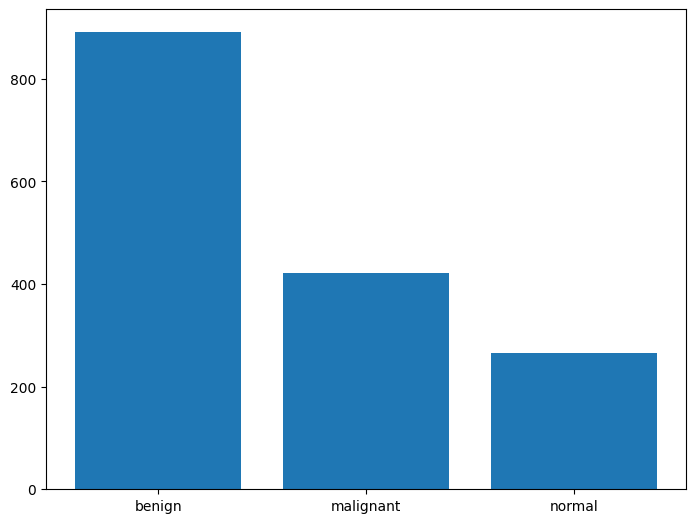

In [ ]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
labels = ['benign','malignant', 'normal']
count_train = [benign,malignant,normal]
ax.bar(labels, count_train)
plt.show()

In [ ]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(1578, 2)


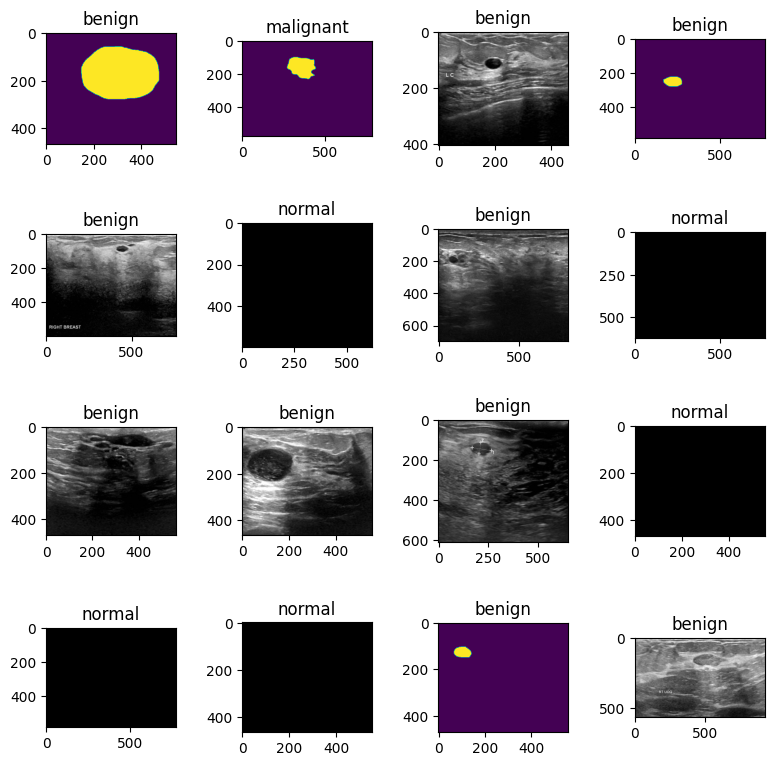

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

## 2. Model

In [ ]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=3,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/data/dataset/Dataset_BUSI_with_GT", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 1578 files belonging to 3 classes.


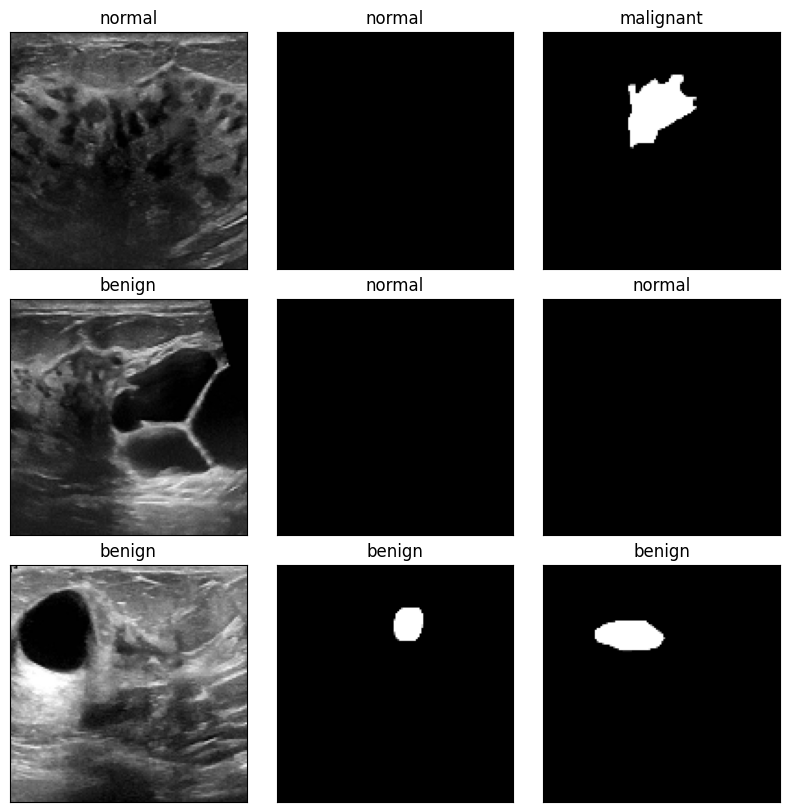

In [ ]:
_ = plot_grid_ds(train_ds)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [ ]:
import time

start = time.time()


model.fit(train_ds, epochs=20, validation_data=validation_ds)
end = time.time()


Epoch 1/20
20/20 [==============================] - 230s 11s/step - loss: 20.6215 - accuracy: 0.4641 - balanced_sparse_categorical_accuracy: 0.4050 - val_loss: 1.6589 - val_accuracy: 0.5168 - val_balanced_sparse_categorical_accuracy: 0.4409
Epoch 2/20
20/20 [==============================] - 253s 13s/step - loss: 1.9846 - accuracy: 0.4750 - balanced_sparse_categorical_accuracy: 0.3959 - val_loss: 1.2895 - val_accuracy: 0.3221 - val_balanced_sparse_categorical_accuracy: 0.4188
Epoch 3/20
20/20 [==============================] - 224s 11s/step - loss: 0.9787 - accuracy: 0.5578 - balanced_sparse_categorical_accuracy: 0.4347 - val_loss: 0.7892 - val_accuracy: 0.5805 - val_balanced_sparse_categorical_accuracy: 0.6186
Epoch 4/20
20/20 [==============================] - 245s 12s/step - loss: 0.8998 - accuracy: 0.5781 - balanced_sparse_categorical_accuracy: 0.4592 - val_loss: 0.8847 - val_accuracy: 0.6007 - val_balanced_sparse_categorical_accuracy: 0.4907
Epoch 5/20
20/20 [=====================

In [ ]:
print(end - start)

5180.148948431015


## 3. Results

1/1 [==============================] - 2s 2s/step


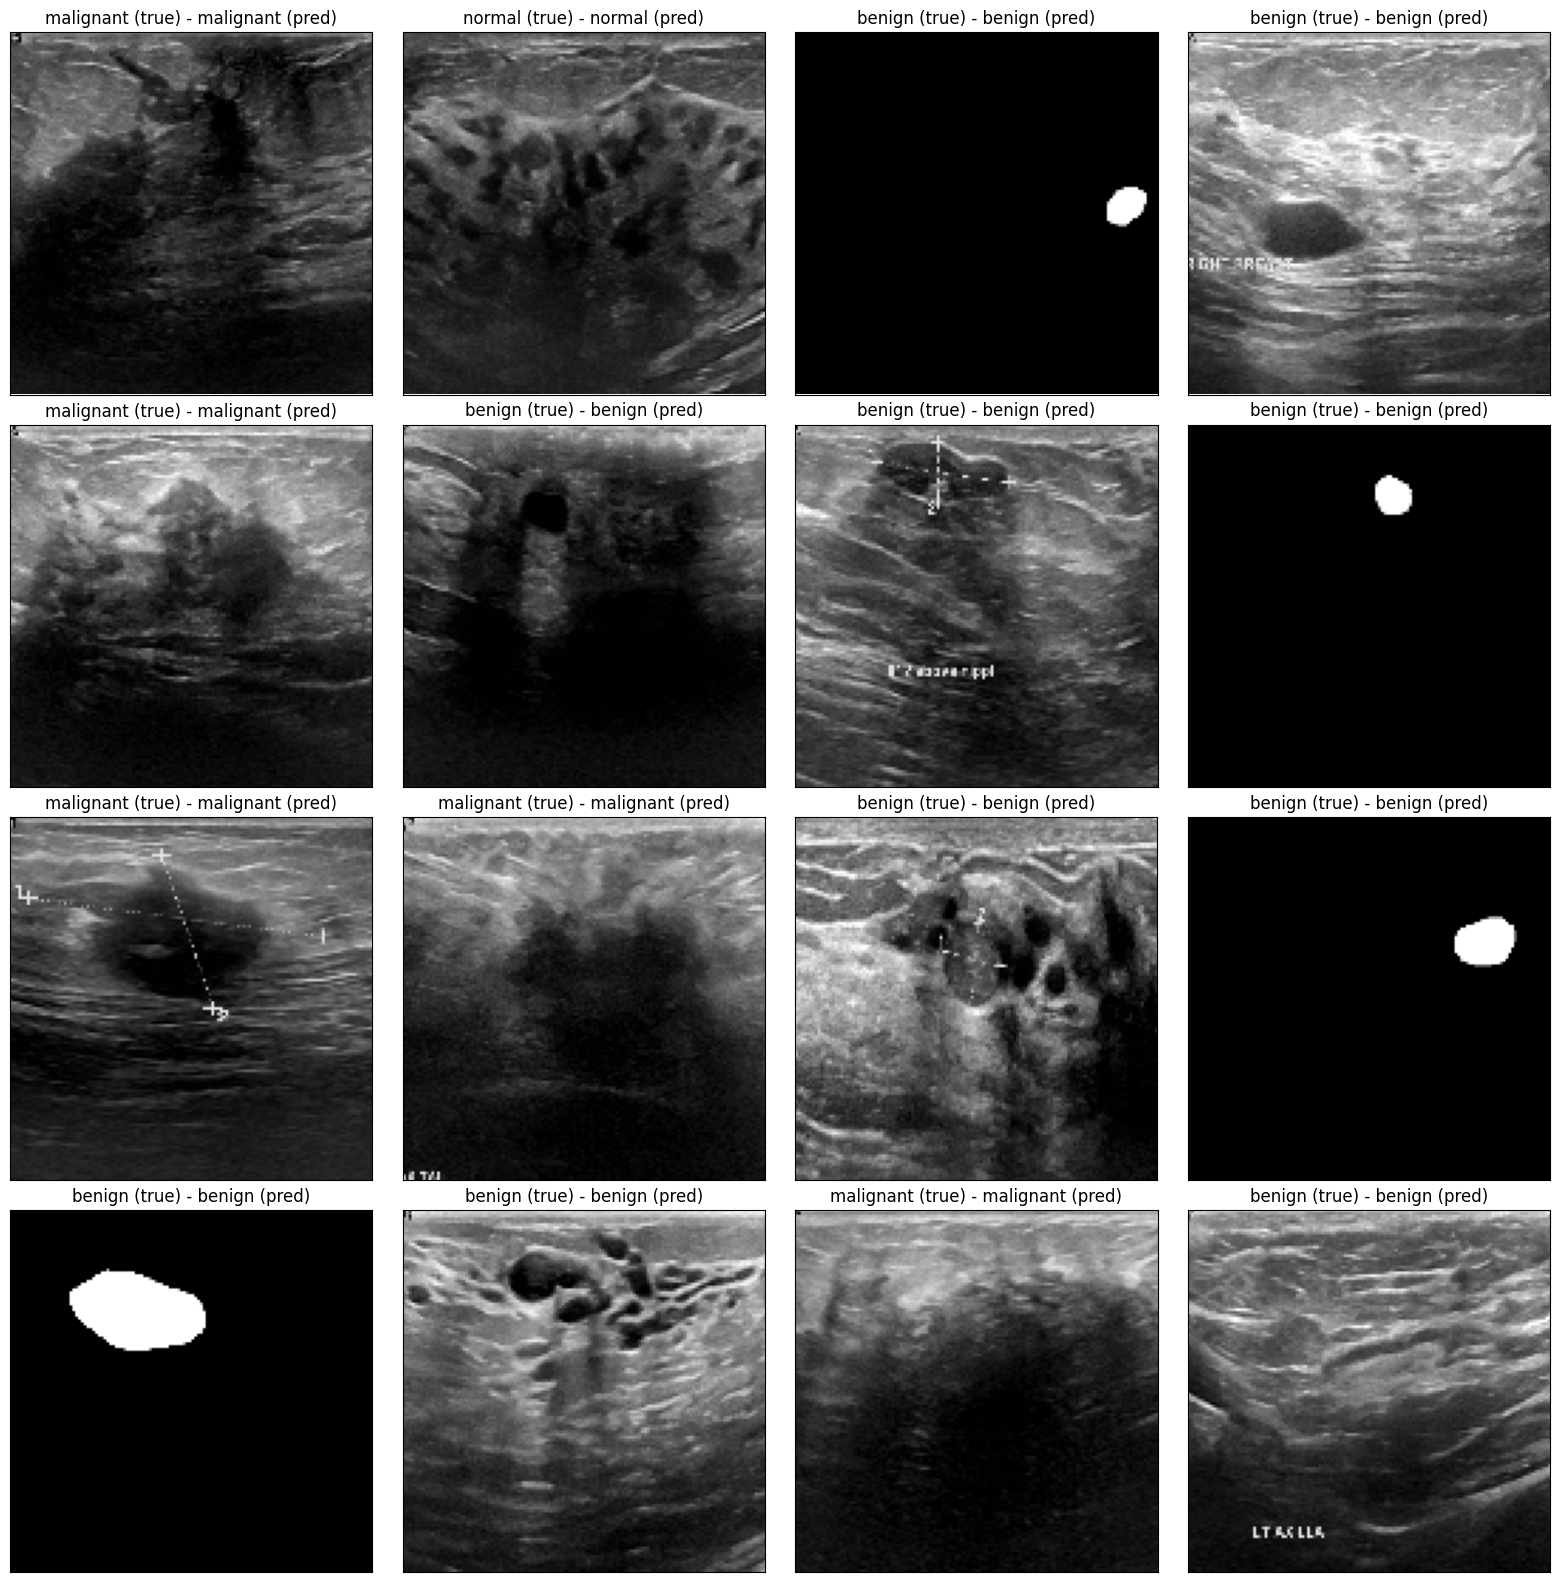

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

Final accuracy on validation set : 0.895


In [ ]:
model.save("models/ViT_on_10_epochs.model")